# Progetto d'esame di Data Analysis in Experimental Physics with Machine Learning

Gruppo composto dagli studenti Luca Attinà, Sharis Feriotto e Matteo Marchisio Caprioglio

Dataset ipotesi: https://www.kaggle.com/datasets/vipoooool/new-plant-diseases-dataset
Questo dataset non va bene perchè ha fatto data aug sul validation dataset, fallback al plant village originale: https://www.tensorflow.org/datasets/catalog/plant_village

In [87]:
# libraries and packages import
import os
import shutil
import random
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow import keras

from keras.models import Sequential
from keras.layers import Conv2D, BatchNormalization, Activation, MaxPooling2D, Dropout, Flatten, Dense
from tensorflow.keras.optimizers import Adam
from keras.losses import CategoricalCrossentropy, CategoricalFocalCrossentropy
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras import regularizers
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, roc_auc_score, classification_report
import seaborn as sns

In [130]:
# Seed setting for reproducibility
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)
tf.keras.utils.set_random_seed(42)


# Data download and preprocess

Be careful if you are running this on COLAB or locally.
Due to some bugs, datasets creation is different.
Change the lower COLAB bool to True if running on COLAB.

In [131]:
COLAB = False  # if True, run on Google Colab, else on local repository


In [148]:
# useful constants
IMG_SIZE = (128, 128)
BATCH_SIZE = 64
N_EPOCHS = 30
VERBOSE = True # True for debug prints


IF RUNNING ON COLAB

In [133]:
# Load the PlantVillage dataset from TFDS instead of the new dataset (it performed data aug on the validation set, which is wrong)
# Only working on Colab (and locally if tfds.load works correctly)

def load_from_tfds():
    (ds_train, ds_val, ds_test), ds_info = tfds.load(
        'plant_village',
        split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
        shuffle_files=True,
        as_supervised=True,  # returns (image, label) pairs
        with_info=True,
    )

    # labels are plant families
    class_names = ds_info.features['label'].names
    families = sorted({n.split('___')[0] for n in class_names})
    split_labels = families
    family_map = tf.constant([families.index(n.split('___')[0]) for n in class_names], dtype=tf.int32)

    # returns label as one-hot
    def to_ohe(img, lbl):
      idx = tf.gather(family_map, lbl)
      return img, tf.one_hot(idx, len(split_labels))

    ds_train = ds_train.map(to_ohe)
    ds_val   = ds_val.map(to_ohe)
    ds_test  = ds_test.map(to_ohe)

    print(split_labels)

    return ds_train, ds_val, ds_test, split_labels, ds_info


In [134]:
# if on colab, define preprocess.py (this is the same function defined in preprocessing.py)
if COLAB:
    def preprocess(image, label, image_size=(128, 128)):
        image = tf.image.resize(image, image_size)
        image = tf.cast(image, tf.float32) / 255.0
        return image, label


IF RUNNING ON LOCAL REPOSITORY

If you are working on a local repository, first of all you need to clone the dataset into a local folder. 
Execute the command "git clone https://github.com/spMohanty/PlantVillage-Dataset" in the terminal while you are in a known path. Make sure to set the base_path variable below to point to that cloned folder. 

Only run the git clone command if you haven’t already downloaded the dataset to your PC.

In [135]:
# Define local path to generate split
if not COLAB:
    from pathlib import Path
    from preprocessing import preprocess

    base_path = Path(r"D:\progetto-daml") #Change according to the path where PlantVillage-Dataset is cloned.
    base_path = base_path / "PlantVillage-Dataset"

    OUTPUT_ROOT = base_path / "by_family" # 14 families splitting
    DS_DIR = OUTPUT_ROOT / "train"


In [ ]:
#ONLY RUN FIRST TIME, AFTER DATASET CLONING
'''
SOURCE_DIR = base_path / "raw/color"
TRAIN_FRAC = 0.8 #change fractions
VAL_FRAC = 0.15
TEST_FRAC = 0.05

# Create output folders
for split in ("train","val","test"):
    folder = OUTPUT_ROOT / split
    if folder.exists():
        shutil.rmtree(folder) #remove pre-existing folder for new split
    folder.mkdir(parents=True, exist_ok=True)

# Collect folders name and map into family name folders
disease_folders = sorted([d for d in SOURCE_DIR.iterdir() if d.is_dir()])
families = sorted({d.name.split("___")[0] for d in disease_folders})

for split in ("train","val","test"):
    for fam in families:
        (OUTPUT_ROOT/ split / fam).mkdir(parents=True, exist_ok=True)

# Splits files into train, validation and test for each family
for disease_dir in disease_folders:
    fam = disease_dir.name.split("___")[0]
    images = list(disease_dir.glob("*.*"))  # all image files
    random.shuffle(images)

    n = len(images)
    n_train = int(n * TRAIN_FRAC)
    n_val   = int(n * VAL_FRAC)

    train_imgs = images[:n_train]
    val_imgs   = images[n_train:n_train+n_val]
    test_imgs  = images[n_train+n_val:]

    # Put the datasets into the local folders
    for img in train_imgs:
        shutil.copy(img, OUTPUT_ROOT/"train"/fam/img.name)
    for img in val_imgs:
        shutil.copy(img, OUTPUT_ROOT/"val"/fam/img.name)
    for img in test_imgs:
        shutil.copy(img, OUTPUT_ROOT/"test"/fam/img.name)

print("Datasets paths are:\n",
    OUTPUT_ROOT / "train\n", 
    OUTPUT_ROOT / "val\n", 
    OUTPUT_ROOT / "test\n")
'''

Datasets paths are:
 D:\progetto-daml\PlantVillage-Dataset\by_family\train
 D:\progetto-daml\PlantVillage-Dataset\by_family\val
 D:\progetto-daml\PlantVillage-Dataset\by_family\test



In [136]:
# read split data into train, validation e test sets
def prepare_local_dataset():
    split_labels = sorted([p.name for p in (OUTPUT_ROOT/"train").iterdir() if p.is_dir()]) #folders names

    ds_train_ohe = tf.keras.utils.image_dataset_from_directory(
        str(OUTPUT_ROOT/"train"),
        image_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        shuffle=True,
        label_mode='categorical',
    )

    ds_val_ohe = tf.keras.utils.image_dataset_from_directory(
        str(OUTPUT_ROOT/"val"),
        image_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        label_mode='categorical',
        shuffle=False,
    )

    ds_test_ohe = tf.keras.utils.image_dataset_from_directory(
        str(OUTPUT_ROOT/"test"),
        image_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        label_mode='categorical',
        shuffle=False,
    )

    return ds_train_ohe, ds_val_ohe, ds_test_ohe, split_labels


# Training


In [137]:
# cnn layers
def simple_cnn(input_shape, num_classes, l2_coef=1e-3):
    model = Sequential([
        Conv2D(16, (3, 3), padding='same', kernel_regularizer=regularizers.l2(l2_coef), input_shape=input_shape),
        BatchNormalization(),
        Activation('relu'),
        Dropout(0.4),

        Conv2D(32, (3, 3), padding='same', kernel_regularizer=regularizers.l2(l2_coef)),
        BatchNormalization(),
        Activation('relu'),
        MaxPooling2D((2, 2)),

        #Conv2D(128, (3, 3), padding='same'),
        #BatchNormalization(),
        #Activation('relu'),
        #MaxPooling2D((2, 2)),
        Dropout(0.4),

        Flatten(),
        #Dense(64, activation='relu'),
        Dense(num_classes, activation='softmax', kernel_regularizer=regularizers.l2(l2_coef))
    ])
    return model


In [138]:
# preprocess and batch datasets. Useful objects are defined
def model_preprocess(COLAB):
    if COLAB:
        ds_train, ds_val, ds_test, split_labels, ds_info = load_from_tfds()
        ds_train = ds_train.shuffle(buffer_size=5000) # only shuffle train set
        ds_train = ds_train.map(lambda img, lbl: preprocess(img, lbl, IMG_SIZE)).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)  # training dataset without data augmentation
        ds_val = ds_val.map(lambda img, lbl: preprocess(img, lbl, IMG_SIZE)).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
        ds_test = ds_test.map(lambda img, lbl: preprocess(img, lbl, IMG_SIZE)).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
    else:
        ds_train, ds_val, ds_test, split_labels = prepare_local_dataset()

    num_classes = len(split_labels)
    checkpoint = "best_model_14_families_focal_newsplit.h5"

    return ds_train, ds_val, ds_test, split_labels, num_classes, checkpoint



In [139]:
# model compilation
def model_train(num_classes):
    model = simple_cnn(input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3), num_classes=num_classes)

    optimizer = Adam(learning_rate=0.001)
    # optimizer = SGD(learning_rate=0.05, momentum=0.9)
    model.compile(
        optimizer=optimizer,
        loss=CategoricalFocalCrossentropy(alpha = 0.25, gamma = 2),
        metrics=['accuracy']
    )

    model.build(input_shape=(None, IMG_SIZE[0], IMG_SIZE[1], 3))  # Build the model with dynamic batch size
    model.summary()
    return model


In [140]:
# program running (all the functions above are executed)
train_set, val_set, test_set, split_labels, num_classes, checkpoint_file = model_preprocess(COLAB)


Found 43429 files belonging to 14 classes.
Found 8129 files belonging to 14 classes.
Found 2747 files belonging to 14 classes.


In [149]:
# debug prints: labels, number of labels, checkpoint file name
if VERBOSE:
    print(split_labels)
    print(len(split_labels))
    print(checkpoint_file)

['Apple', 'Blueberry', 'Cherry', 'Corn', 'Grape', 'Orange', 'Peach', 'Pepper,_bell', 'Potato', 'Raspberry', 'Soybean', 'Squash', 'Strawberry', 'Tomato']
14
best_model_14_families_focal_newsplit.h5


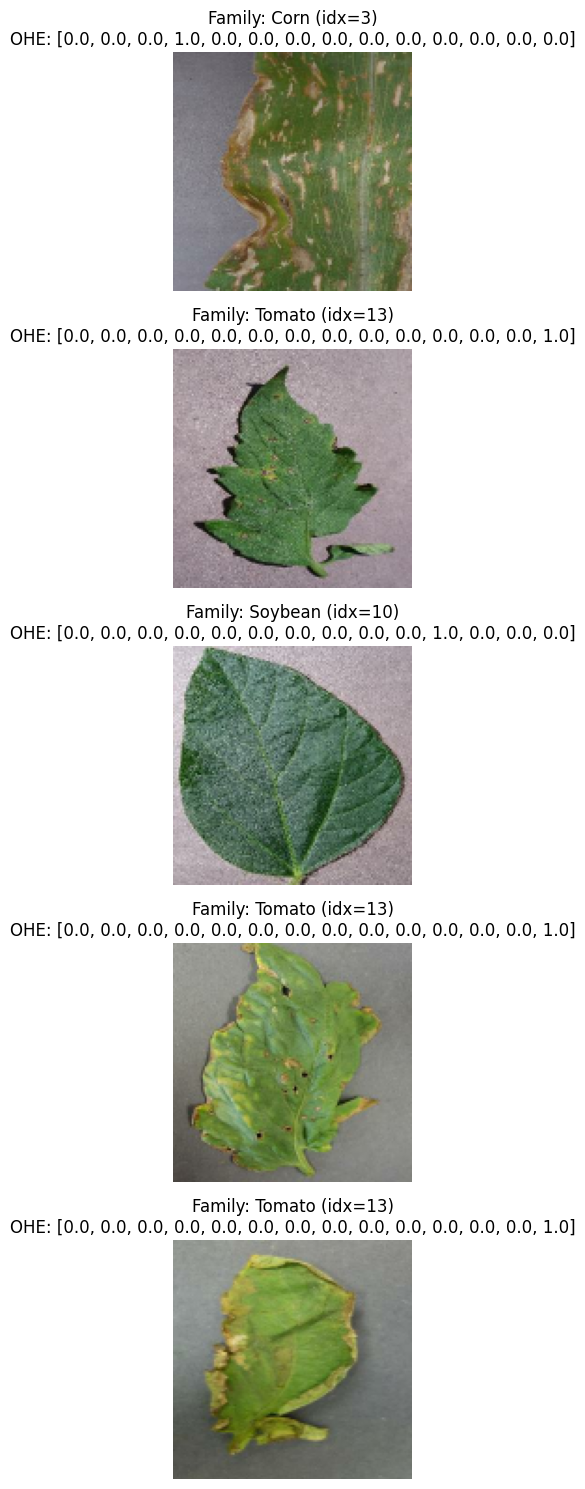

In [150]:
# debug print for families - ohe labels cross check
def display_samples_with_labels_ohe(dataset, num_samples=5):
    plt.figure(figsize=(6, 3 * num_samples))
    for i, (img, label_ohe) in enumerate(dataset.unbatch().take(num_samples)):
        # Tensors are converted into numpy arrays
        img_np   = img.numpy().astype("uint8")
        ohe_vec  = label_ohe.numpy()                     # one-hot vector
        fam_idx  = int(tf.argmax(label_ohe).numpy())     # family index
        fam_name = split_labels[fam_idx]

        ax = plt.subplot(num_samples, 1, i + 1)
        plt.imshow(img_np)
        plt.axis("off")
        plt.title(f"Family: {fam_name} (idx={fam_idx})\nOHE: {ohe_vec.tolist()}")
    plt.tight_layout()
    plt.show()

# example on train batch
if VERBOSE:
    display_samples_with_labels_ohe(train_set, num_samples=5)


In [151]:
# counting number of images per class
from collections import Counter

if VERBOSE:
    counts = Counter()
    
    for _, batch_labels in train_set:
        idxs = np.argmax(batch_labels.numpy(), axis=1)
        counts.update(idxs)
    
    print(f"Number of classes: {len(split_labels)}")
    print("Number of images per class:")
    for idx in range(len(split_labels)):
        print(f"{split_labels[idx]}: {counts[idx]} images")


Number of classes: 14
Number of images per class:
Apple: 2536 images
Blueberry: 1201 images
Cherry: 1524 images
Corn: 3080 images
Grape: 3248 images
Orange: 4405 images
Peach: 2125 images
Pepper,_bell: 1979 images
Potato: 1721 images
Raspberry: 296 images
Soybean: 4072 images
Squash: 1468 images
Strawberry: 1251 images
Tomato: 14523 images


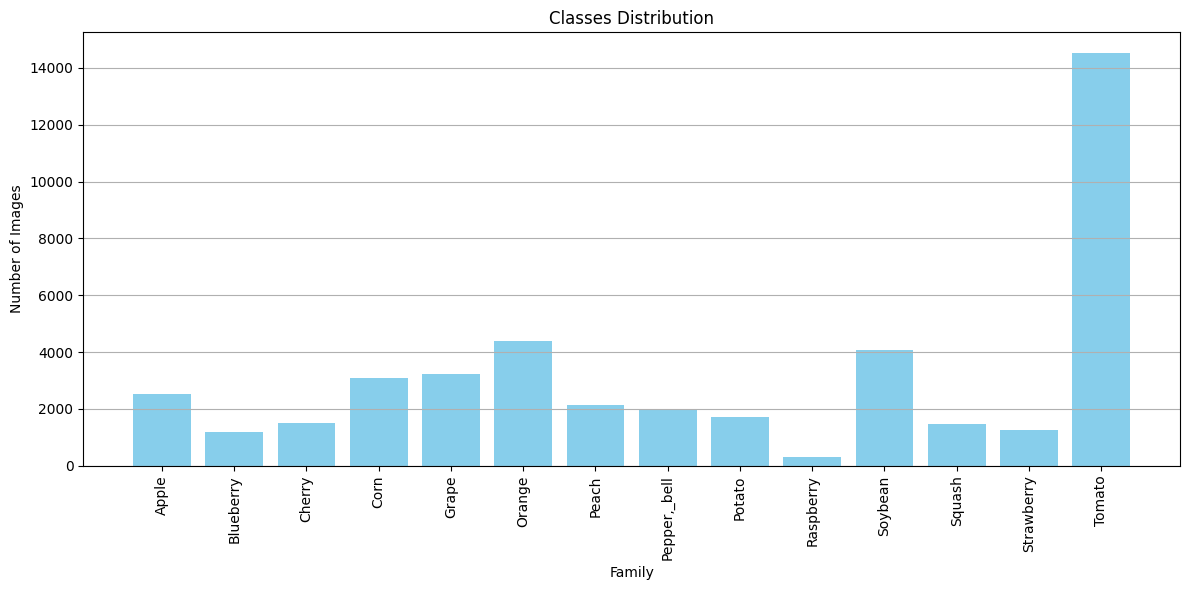

In [152]:
# Visualize the class numbers distribution
if VERBOSE:
    counts_list = [counts[i] for i in range(len(split_labels))]

    plt.figure(figsize=(12, 6))
    plt.bar(split_labels, counts_list, color='skyblue')
    plt.xlabel('Family')
    plt.ylabel('Number of Images')
    plt.title('Classes Distribution')
    plt.xticks(rotation=90)
    plt.grid(axis='y')
    plt.tight_layout()
    plt.show()


In [145]:
# Print element format
if VERBOSE:
    print("Element spec:", train_set.element_spec)
    
    # Example on a batch
    for batch in train_set.take(1):
        x, y = batch
        print("x shape:", x.shape, "  dtype:", x.dtype)
        print("y shape:", y.shape, "  dtype:", y.dtype)


In [153]:
model = model_train(num_classes)


c:\Users\Utente\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_10 (Conv2D)              │ (None, 128, 128, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 128, 128, 16)   │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_10 (Activation)      │ (None, 128, 128, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 128, 128, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 128, 128, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_11 (Activation)      │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 131072)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 14)             │     1,835,022 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,840,302 (7.02 MB)

 Trainable params: 1,840,206 (7.02 MB)

 Non-trainable params: 96 (384.00 B)

In [ ]:
# Model training - Saving best model
history = model.fit(
    train_set,
    validation_data=val_set,
    epochs=N_EPOCHS,
    callbacks=[
        EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True, verbose=1),
        ModelCheckpoint(checkpoint_file, monitor='val_loss', save_best_only=True, verbose=1),
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2)
    ]
)


Epoch 1/30
 67/679 ━━━━━━━━━━━━━━━━━━━━ 10:30 1s/step - accuracy: 0.1227 - loss: 3.4005

KeyboardInterrupt: 

# CNN training history


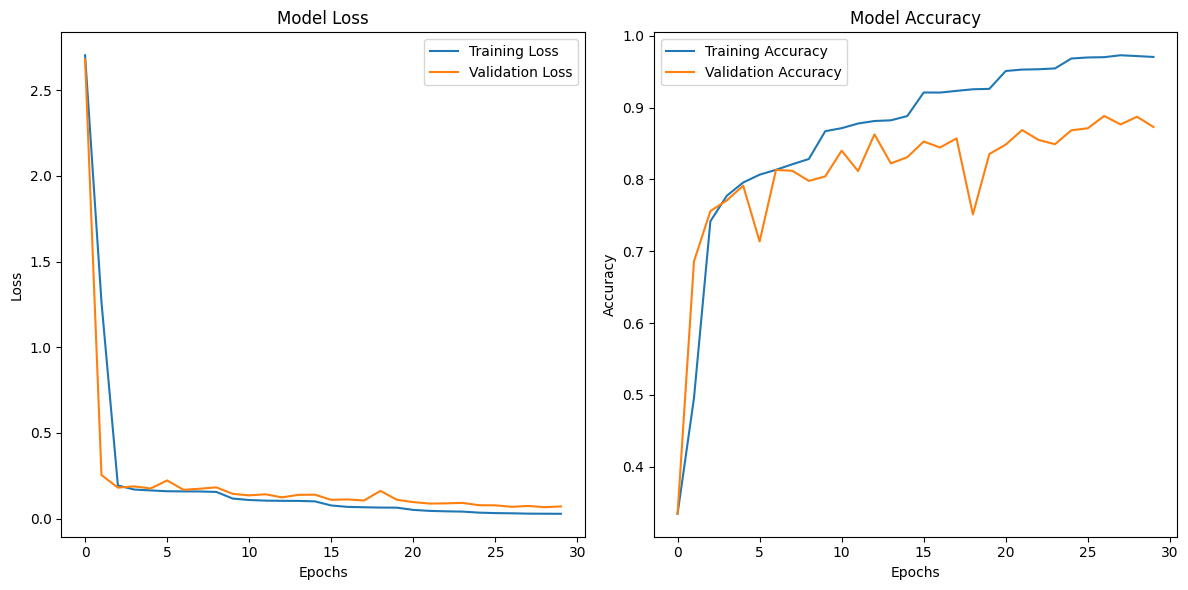

In [76]:
# plot training history (Loss and Accuracy)
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()
plt.show()


# Evaluation code

In [85]:
# Generate Predictions on Test Set
from tensorflow.keras import Sequential

#with keras.utils.custom_object_scope({'Sequential': Sequential}):
#model = keras.models.load_model('best_model_14_families.h5', compile=False)

y_true = [] # ground truth
y_pred = [] # prediction
y_score = [] # predictions vector
for images, labels in test_set:
    y_true.extend(np.argmax(labels.numpy(), axis=1))
    preds = model.predict(images)
    y_pred.extend(np.argmax(preds, axis=1))
    y_score.append(preds)
y_score = np.concatenate(y_score)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 357ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms

In [78]:
# Calculate Evaluation Metrics (Accuracy, Precision, Recall, F1)
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')
print(f"Accuracy: {accuracy:.6f}")
print(f"Precision: {precision:.6f}")
print(f"Recall: {recall:.6f}")
print(f"F1-score: {f1:.6f}")


Accuracy: 0.888258
Precision: 0.901409
Recall: 0.888258
F1-score: 0.890904


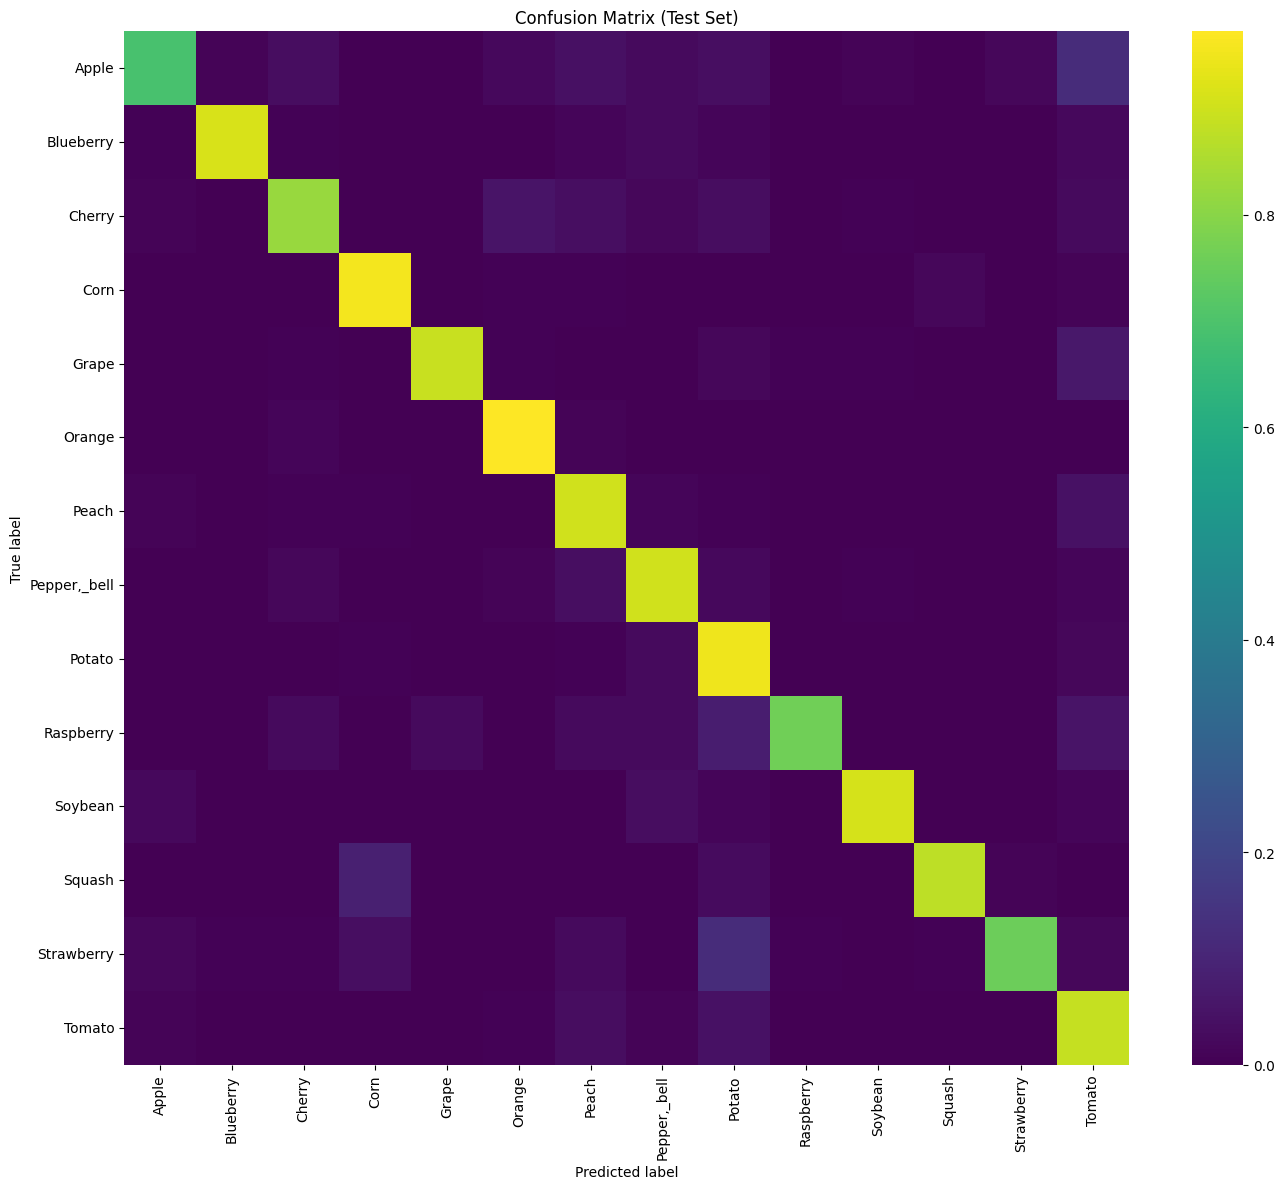

In [79]:
# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred, normalize='true')

#Plot confusion matrix
plt.figure(figsize=(14, 12))
sns.heatmap(cm, annot=False, fmt='d', cmap='viridis', xticklabels=split_labels, yticklabels=split_labels)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix (Test Set)')
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


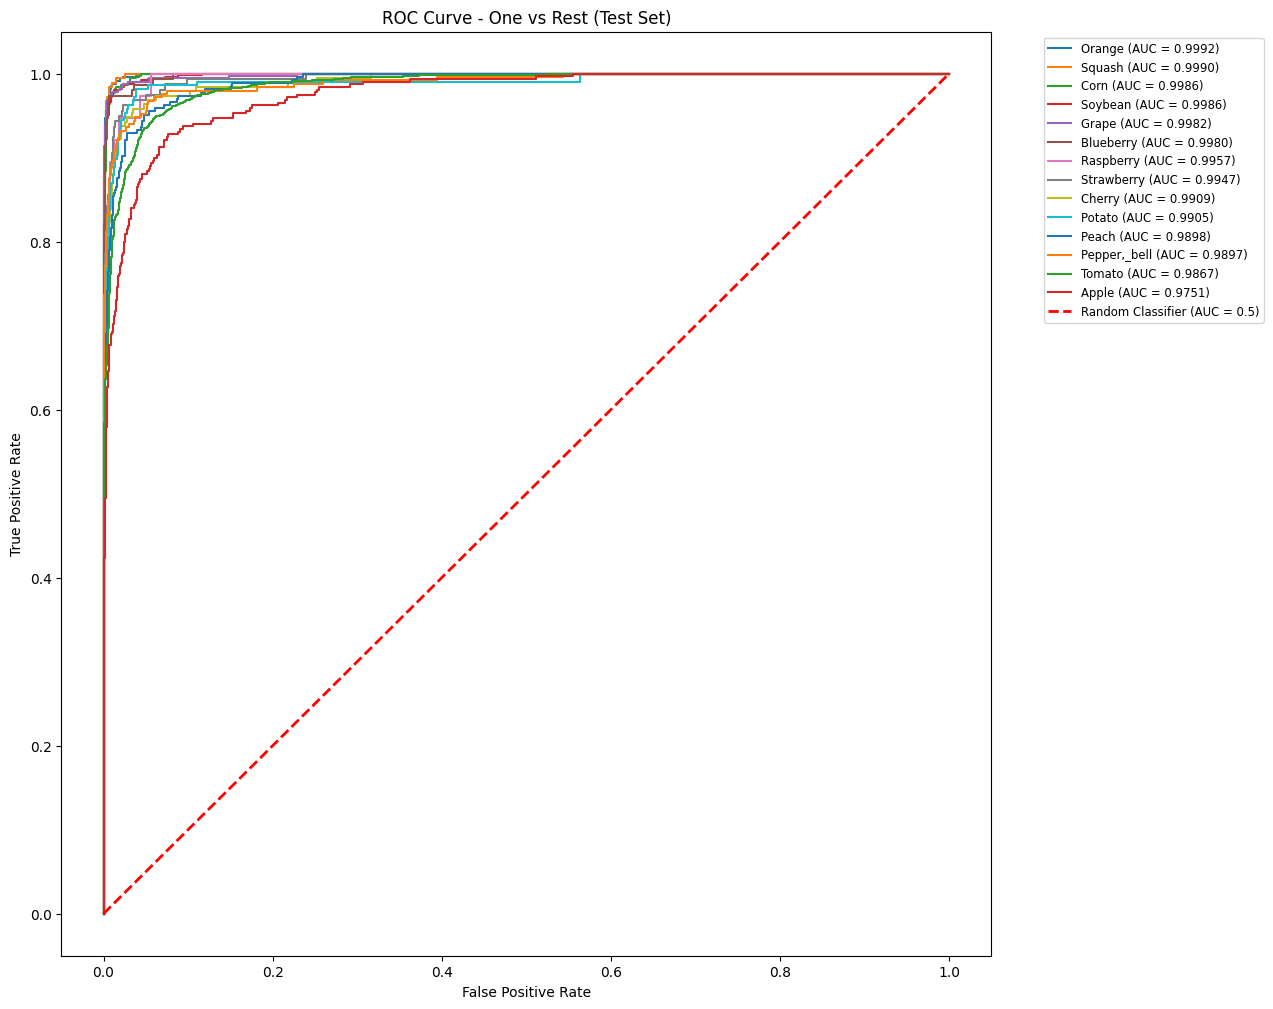

In [80]:
# Plot ROC Curves for Each Class
n_classes = y_score.shape[1]
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(np.eye(n_classes)[y_true][:, i], y_score[:, i])
    roc_auc[i] = roc_auc_score(np.eye(n_classes)[y_true][:, i], y_score[:, i])
plt.figure(figsize=(12, 12))
auc_and_idx = sorted([(roc_auc[i], i) for i in range(n_classes)], reverse=True)
for auc, i in auc_and_idx:
    plt.plot(fpr[i], tpr[i], label=f'{split_labels[i]} (AUC = {auc:.4f})')
plt.plot([0, 1], [0, 1], 'r--', lw=2, label='Random Classifier (AUC = 0.5)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - One vs Rest (Test Set)')
plt.legend(fontsize='small', bbox_to_anchor=(1.05, 1), loc='best')

plt.show()


In [84]:
# Display Classification Report
report = classification_report(y_true, y_pred, target_names=split_labels)
print(report)


              precision    recall  f1-score   support

       Apple       0.84      0.69      0.76       319
   Blueberry       0.94      0.91      0.93       151
      Cherry       0.82      0.82      0.82       192
        Corn       0.93      0.96      0.94       388
       Grape       0.99      0.89      0.94       409
      Orange       0.94      0.97      0.96       552
       Peach       0.70      0.90      0.79       267
Pepper,_bell       0.79      0.90      0.84       250
      Potato       0.58      0.95      0.72       216
   Raspberry       0.76      0.76      0.76        38
     Soybean       0.98      0.91      0.94       509
      Squash       0.95      0.88      0.91       184
  Strawberry       0.91      0.75      0.82       159
      Tomato       0.94      0.89      0.91      1825

    accuracy                           0.89      5459
   macro avg       0.86      0.87      0.86      5459
weighted avg       0.90      0.89      0.89      5459

